# 인공신경망 ANN

키워드 : 인공신경망, 텐서플로, 밀집층, 원-핫 인코딩

* 데이터 다운로드

In [2]:
from tensorflow import keras
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

* 데이터의 크기 확인

In [3]:
print(train_input.shape, train_target.shape)

(60000, 28, 28) (60000,)


* 테스트 데이터 크기 확인

In [4]:
print(test_input.shape, test_target.shape)

(10000, 28, 28) (10000,)


* 데이터 이미지로 확인하기

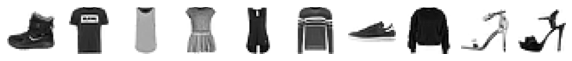

In [5]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,10, figsize=(10,10))
for i in range(10):
    axs[i].imshow(train_input[i], cmap="gray_r")
    axs[i].axis("off")
plt.show()

* MNIST 의 타겟 값 0~9까지의 숫자 레이블

* 0:티셔츠, 1:바지, 2:스웨터, 3:드레스, 4:코트
* 5:샌달, 6:셔츠, 7:스니커즈, 8:가방, 9:앵클부츠

In [6]:
print([train_target[i] for i in range(10)])

[9, 0, 0, 3, 0, 2, 7, 2, 5, 5]


* 타켓별 데이터 개수 확인

`np.unique(data, return_counts = True)` 외우기!!

In [7]:
import numpy as np
print(np.unique(train_target, return_counts=True))
# 각 6000개씩 있는것을 확인

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000],
      dtype=int64))


* 데이터가 60000개 이기때문에 샘플을 하나씩 꺼내서 훈련하는것이 효율적임
* **경사하강법** 을 사용

## 로지스틱 회귀 적용

* `SGDClassifier`
* 표준화 전처리된 데이터 사용

> * 이미지의 경우 0 ~ 255 값을 0 ~ 1 의값으로 정규화를 많이 함

> * reshape() 를 활용하여 2차원 데이터를 1차원 배열로 펼침

In [8]:
print(train_input.shape, train_target.shape)

(60000, 28, 28) (60000,)


In [9]:
train_scaled = train_input / 255
train_scaled = train_scaled.reshape(-1, 28*28)
print(train_scaled.shape)

(60000, 784)


* 전처리된 데이터를 `cross_validate` 함수를 통해 교차 검증으로 성능을 확인

0.8192833333333333
0.8192833333333333


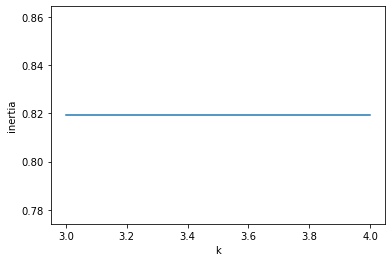

In [10]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt 

test_sc = []
for i in range(3,5):
    sgd = SGDClassifier(loss="log", max_iter=5, random_state=42)
    scores = cross_validate(sgd, train_scaled, train_target, n_jobs=-1)
    print(np.mean(scores["test_score"]))
    test_sc.append(np.mean(scores["test_score"]))

plt.plot(range(3,5), test_sc)
plt.xlabel("k")
plt.ylabel("inertia")
plt.show()

## 반복횟수를 3~9 로 늘려도 성능이 향상되지 않는것을 볼 수 있다.

* 로지스틱 회귀의 특성으로 특성의 개수+1 개만큼 항이 생긴다.
* 이 데이터에는 784개의 특성이 있으므로 항이 785개가 생긴다.
* 즉 가중치가 785개 이다.
* 여기서 10개의 타겟 종류가 있으므로 가중치 785개를 10번 찾아야한다.

## 인공신경망 시작

* 인공신경망의 용어
> 1. 10개의 타겟 = `출력층` output layer
> 1. z 값을 계산하는 단위 = `뉴런, 유닛`
> 1. x1~x784(픽셀) = `입력층` input layer
> 1. 입력층, 출력층이 각각 모두 연결된 층 = `밀집층` dense layer, 완전연결층

* 인공신경망에서는 교차검증을 잘 사용하지 않는다
* 그 대신 검증 세트를 별도로 덜어내어 사용한다.
> 그 이유는 딥러닝 분야의 데이터셋은 충분히 크기 때문에 검증 점수가 안정적이다.
> 또한 교차 검증을 수행하기에는 시간이 너무 오래 걸리기 때문이다.

In [11]:
from tensorflow import keras

* 훈련 train 세트에서 검증 val 세트을 20% 덜어낸다.

In [12]:
from sklearn.model_selection import train_test_split
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

In [13]:
# 훈련세트
print(train_scaled.shape, train_target.shape)

(48000, 784) (48000,)


In [14]:
# 검증세트
print(val_scaled.shape, val_scaled.shape)

(12000, 784) (12000, 784)


### 모델 생성

* dense 설정

1. 10 => 뉴런 개수
1. activation = "softmax" => 뉴런의 출력에 적용할 함수 
1. input_shape(784,) => 입력의 크기  

In [15]:
dense = keras.layers.Dense(10, activation="softmax", input_shape=(784,))

> 1. `시그모이드 함수` -> 하나의 선형 방정식의 출력값을 0~1 로 압축
> 1. `소프트맥스 함수` -> 여러개의 선형 방정식의 출력값을 0~1 로 압축한뒤 전체 합이 1이 되도록 하고 여기서 지수 함수를 사용하기 때문에 정규화된 지수 함수라고도 함
> 1. 즉 다층연결인 신경망에서는 소프트맥스, 2개의 클래스를 분류하는 이진 분류라면 시그모이드를 사용
> 1. 소프트맥스와 같이 뉴런의 선형방정식 계산경과에 적용되는 함수를 `활성화 함수`라고 한다.



* **모델 생성 `keras.Sequential(dense)`**

In [16]:
model = keras.Sequential(dense)

### 분류하기

* 손실 함수 지정하기 

In [17]:
model.compile(loss="sparse_categorical_crossentropy", metrics='accuracy')

#### 손실함수 loss

> 1. 이진분류 loss : "binary_crossentropy"
> 1. 다중분류 loss : "categorical_crossentropy"

* 타깃값을 해당 클래스만 1이고 나머지는 모두 0인 배열로 만드는 것을 `원-핫 인코딩`, `one-hot encoding`이라고 한다.

> 1. 하지만 Tensorflow 에서는 정수로 된 타깃값을 원-핫 인코딩 하지 않고도 사용할 수 있다.
> 1. 이때 정수로된 타깃값을 사용해 손실 계산을 할때 `sparse (희소)`라는 이름을 사용한다. 

* 따라서 정수로된 타깃값의 손실을 계산할때는 `sparse_categorical_crossentropy`를 사용한다.

#### 계량적 분석 metrics

> 1. 기본값으로 손실값을 출력해준다.
> 1. 추가로 훈련이 잘 되고있는지 볼수있는 정확도를 보고싶을때 metrics 를 사용한다.
> 1. metrics="accuracy" 옵션을 추가하면 된다.

In [18]:
model.fit(train_scaled, train_target, epochs=5)

Epoch 1/5
1500/1500 [==============================] - 2s 1ms/step - loss: 0.6067 - accuracy: 0.7943
Epoch 2/5
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4790 - accuracy: 0.8393
Epoch 3/5
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4567 - accuracy: 0.8468
Epoch 4/5
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4456 - accuracy: 0.8523
Epoch 5/5
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4365 - accuracy: 0.8557


### 검증하기

`evaluate()`

In [19]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 1ms/step - loss: 0.4425 - accuracy: 0.8501


[0.44254252314567566, 0.8500833511352539]

# 심층 신경망 DNN

키워드 : 심층 신경망, 렐루 함수, 옵티마이저

* 인공신경망에 층을 여러개 추가하여 심층 신경망을 제작

In [20]:
from tensorflow import keras
(train_input, train_target) , (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

In [21]:
train_input.shape

(60000, 28, 28)

In [22]:
from sklearn.model_selection import train_test_split

train_scaled = train_input /255.0
train_scaled = train_scaled.reshape(-1, 28*28)
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

In [23]:
train_scaled.shape

(48000, 784)

## 은닉층

* 입력층과 출력층 사이에 밀집층이 추가된 것

* 은닉층은 활성화 함수가 함께있다.

* 활성화 함수로는 시그모이드함수, 렐루(ReLU)함수를 사용한다.

## 심층 신경만 만들기

**그냥 모델 만들기**

In [24]:
dense1 = keras.layers.Dense(100, activation="sigmoid", input_shape=(784,)) # 은닉층
dense2 = keras.layers.Dense(10,activation="softmax") # 출력층

In [25]:
model = keras.Sequential([dense1, dense2])
# model = keras.Sequential(dense)  => 인공신경망 만들기
# [ ] 를 통해 은닉층, 출력층을 넣어주는 차이가 있음

In [26]:
model.summary()
# 모델을 제작했지 데이터를 넣어주지는 않음

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 100)               78500     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


**index 들을 넣어서 model 제작**

In [27]:
dense1 = keras.layers.Dense(100, activation="sigmoid", input_shape=(784,), name="hidden")
dense2 = keras.layers.Dense(10, activation="softmax", name="output")

In [28]:
model = keras.Sequential([dense1, dense2], name="패션 MNIST 모델")

In [29]:
model.summary()

Model: "패션 MNIST 모델"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (Dense)              (None, 100)               78500     
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


**add를 통해 층 바로넣기**

In [30]:
model = keras.Sequential()
model.add(keras.layers.Dense(100, activation="sigmoid", input_shape = (784,)))
model.add(keras.layers.Dense(10, activation="softmax"))

**모델 훈련하기**

In [31]:
model.compile(loss="sparse_categorical_crossentropy", metrics="accuracy")

에포크 5

In [32]:
model.fit(train_scaled, train_target, epochs=5)

Epoch 1/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5590 - accuracy: 0.8080
Epoch 2/5
1500/1500 [==============================] - 2s 2ms/step - loss: 0.4072 - accuracy: 0.8544
Epoch 3/5
1500/1500 [==============================] - 2s 2ms/step - loss: 0.3729 - accuracy: 0.8648
Epoch 4/5
1500/1500 [==============================] - 2s 2ms/step - loss: 0.3502 - accuracy: 0.8736
Epoch 5/5
1500/1500 [==============================] - 2s 2ms/step - loss: 0.3324 - accuracy: 0.8795


에포크 10

In [33]:
model.fit(train_scaled, train_target, epochs=10)

Epoch 1/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3184 - accuracy: 0.8848
Epoch 2/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.3082 - accuracy: 0.8874
Epoch 3/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2986 - accuracy: 0.8902
Epoch 4/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2901 - accuracy: 0.8944
Epoch 5/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2802 - accuracy: 0.8981
Epoch 6/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2746 - accuracy: 0.8996
Epoch 7/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2678 - accuracy: 0.9028
Epoch 8/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2613 - accuracy: 0.9045
Epoch 9/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2558 - accuracy: 0.9061
Epoch 10/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.249

## 렐루함수

* 시그모이드 함수가 유선형의 곡선으로 모든 신경망에서 계산하면 신속하게 대응하기 힘들다는 단점이 있다.
* 렐루함수는 양수는 통과, 음수는 0 으로 만든다

## Flatten 층

* 다차원을 1차원으로
* 입력층과 은닉층 사이에서 다차원의 데이터를 1차원 배열로 만드는 역할을 한다.
* 가중치나 절편은 없다

In [34]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(28,28)))
model.add(keras.layers.Dense(100, activation="relu", input_shape = (784,)))
model.add(keras.layers.Dense(10, activation="softmax"))

In [35]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 100)               78500     
                                                                 
 dense_6 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [36]:
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input/ 255
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

In [37]:
model.compile(loss="sparse_categorical_crossentropy", metrics="accuracy")
model.fit(train_scaled, train_target, epochs=5)

Epoch 1/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5278 - accuracy: 0.8147
Epoch 2/5
1500/1500 [==============================] - 2s 2ms/step - loss: 0.3897 - accuracy: 0.8596
Epoch 3/5
1500/1500 [==============================] - 2s 2ms/step - loss: 0.3529 - accuracy: 0.8734
Epoch 4/5
1500/1500 [==============================] - 2s 2ms/step - loss: 0.3354 - accuracy: 0.8794
Epoch 5/5
1500/1500 [==============================] - 2s 2ms/step - loss: 0.3223 - accuracy: 0.8858


## 검증하기

In [38]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 1ms/step - loss: 0.3631 - accuracy: 0.8762


[0.3630901277065277, 0.8761666417121887]

## 옵티마이저

다양한 종류의 경사하강법

In [39]:
# 여기서 "sgd" 는 sgd=keras.optimizers.SGD() 를 대신한다.

model.compile(optimizer="sgd", loss="sparse_categorical_crossentropy", metrics="accuracy")

### 기본 경사하강법 옵티마이저

#### 학습률

In [40]:
sgd = keras.optimizers.SGD(learning_rate=0.1)

#### 모멘텀 최적화
* 모멘텀 0보다 크게 변경 (기본값 0)
* 그레이디언트를 가속도 처럼 사용

In [41]:
sgd = keras.optimizers.SGD(momentum=0.9)

#### 네스테로프 모멘텀 최적화 
* 네스테로프 가속 경사
* 모멘텀 최적화를 2번 반복하여 구현
* 일반적으로 기본 확률적 경사 하강법 보다 좋은 성능을 보인다

In [42]:
sgd = keras.optimizers.SGD(momentum=0.9, nesterov=True)

### 적응적 학습률 옵티마이저

* 모델이 최적점에 가까이 갈수록 학습률을 낮출 수 있다.
* 안정적으로 최적점에 수렴할 가능성이 증가


* 아래 3개 모델은 전부 learning_rate 기본값 0.001을 사용한다.

In [43]:
adagrad = keras.optimizers.Adagrad()

In [44]:
rmsprop = keras.optimizers.RMSprop()

In [45]:
adam = keras.optimizers.Adam()

In [46]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(28,28)))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [47]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics ="accuracy")

In [48]:
model.fit(train_scaled, train_target, epochs=5)

Epoch 1/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5300 - accuracy: 0.8141
Epoch 2/5
1500/1500 [==============================] - 2s 2ms/step - loss: 0.3976 - accuracy: 0.8581
Epoch 3/5
1500/1500 [==============================] - 2s 2ms/step - loss: 0.3560 - accuracy: 0.8716
Epoch 4/5
1500/1500 [==============================] - 2s 2ms/step - loss: 0.3279 - accuracy: 0.8819
Epoch 5/5
1500/1500 [==============================] - 2s 2ms/step - loss: 0.3089 - accuracy: 0.8872


In [49]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 1ms/step - loss: 0.3348 - accuracy: 0.8807


[0.3348294794559479, 0.8806666731834412]

# 신경망 모델 훈련

In [50]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input/255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

In [51]:
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    model.add(keras.layers.Dense(100, activation="relu"))
    if a_layer:
        model.add(a_layer)
    model.add(keras.layers.Dense(10, activation="softmax"))
    return model

In [52]:
model = model_fn()
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 100)               78500     
                                                                 
 dense_10 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.compile(loss="sparse_categorical_crossentropy", metrics="accuracy")
history = model.fit(train_scaled, train_target, epochs=5, verbose=0)
# verbose=0  -> 훈련과정을 나타내지 않음
# verbose=1  -> 기본값, 진행막대, 지표들 출력
# verbose=2  -> 진행막대 제거

In [54]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


## 그래프 그리기

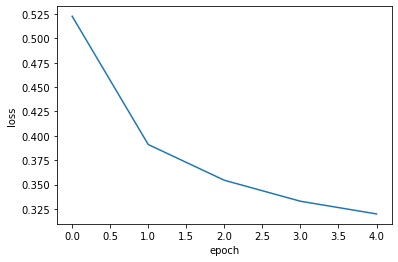

In [55]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

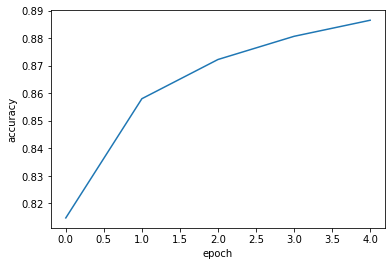

In [56]:
plt.plot(history.history["accuracy"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

* 훈련 epoch 20으로 증가

In [57]:
model = model_fn()
model.compile(loss="sparse_categorical_crossentropy", metrics = "accuracy")
history = model.fit(train_scaled, train_target, epochs=20, verbose=0)

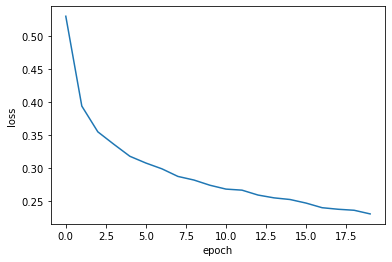

In [58]:
plt.plot(history.history["loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

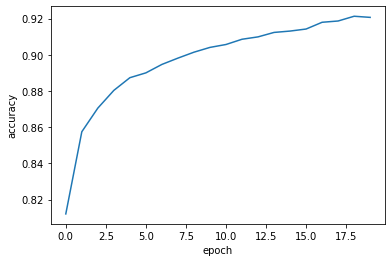

In [59]:
plt.plot(history.history["accuracy"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

* 정확도가 오르고 손실률이 감소했다고 다 좋은것이 아니다.
---

## 검증 손실

* 과대/과소적합 확인

* 정확도를 확인하는 것 보다 손실 함수의 값을 확인하는 것이 더 중요하다.

In [60]:
model = model_fn()
model.compile(loss="sparse_categorical_crossentropy", metrics="accuracy")
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

In [61]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


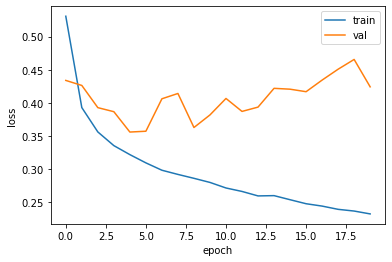

In [62]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "val"])
plt.show()

* 초기에는 점수가 감소하다가 점점 검증 손실이 증가하는 것을 볼 수 있다.
* 훈련 모델은 꾸준히 감소하기 때문에 이대로는 전형적인 과대적합 모델이 만들어진다.
* 검증 손실이 상승 하는 시점을 뒤로 미뤄야 한다.

## 옵티마이저 적용

In [63]:
model = model_fn()
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

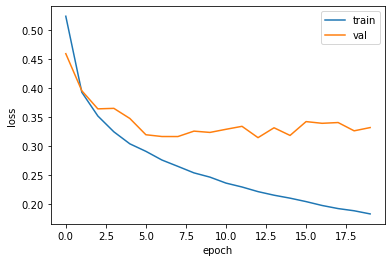

In [64]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "val"])
plt.show()

* RMSprop 방법을 썼을 때 보다 과대적합이 훨씬 줄어든것을 볼 수 있다.
* 여전히 요동은 남아있지만 8~10번째 까지 전반적인 감소를 확인할 수 있다.
* 더 나은 손실 곡선을 얻으려면 학습률을 조정해서 다시 시도해 볼 수 도있다.

* 학습률 0.01

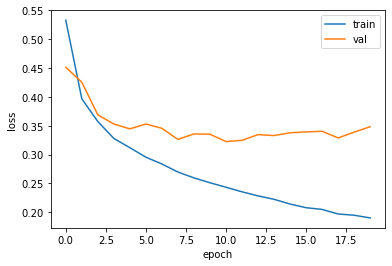

In [65]:
adam = keras.optimizers.Adam(learning_rate=0.01)
model = model_fn()
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "val"])
plt.show()

* 학습률 0.1

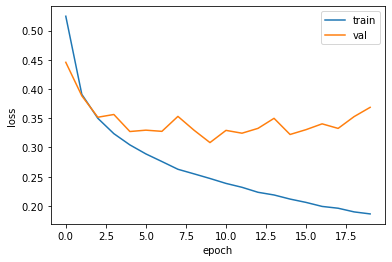

In [66]:
adam = keras.optimizers.Adam(learning_rate=0.1)
model = model_fn()
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "val"])
plt.show()

* 위처럼 손실함수를 잘 조절하는것이 실력의 핵심이다.

## 드롭아웃 dropout

* 훈련 과정중에 층에 있는 일부 뉴런을 랜덤하게 꺼서 과대적합을 막습니다.

* 얼마나 많은 뉴런을 드롭할지는 또 다른 하이퍼 파라미터이다.

* 드롭아웃은 앙상블 기법과 모습이 흡사하고 그 결과 과대적합을 막는 것까지도 비슷하다.

* 드롭아웃 레이어를 만들어서 추가하는 형태로 적용할 수 있다.

In [67]:
model = model_fn(keras.layers.Dropout(0.3))
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 dense_21 (Dense)            (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_22 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


* 훈련이 끝나고 평가, 예측을 할때는 드롭아웃을 적용하지 않아야 한다. 모든 뉴런을 사용해야 올바른 예측을 할 수 있다.

* 텐서플로우의 케라스는 이를 자동으로 해줍니다 ^^7

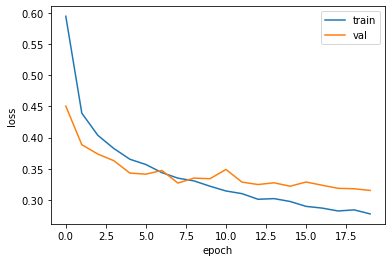

In [68]:
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics="accuracy")
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "val"])
plt.show()

* 과대적합이 epoch 13 정도까지 꾸준하게 감소하는 것을 확인할 수 있다.

* 그렇다면 에포크를 10으로 지정하고 훈련한뒤 저장을 한다.

## 모델 저장

In [69]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics="accuracy")
history = model.fit(train_scaled, train_target, epochs=10, verbose=0, validation_data=(val_scaled,val_target))

* 모델의 파라미터를 저장

In [70]:
model.save_weights("model-weights.h5")

* 모델 구조와 모델 파라미터를 함께 저장

In [71]:
model.save("model-whole.h5")

## 모델 복원

* 파라미터 불러오기 - 정확히 같은 구조만 불러올수있다.

In [72]:
model = model_fn(keras.layers.Dropout(0.3))
model.load_weights("model-weights.h5")

### 검증

1. predict() 메서드는 12000,10 크기의 배열을 반환한다.
1. 10개의 확률중에 가장 큰 값의 인덱스를 골랄 타깃 레이블과 비교하여 정확도를 계산해본다.

In [73]:
import numpy as np
val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels == val_target))

0.8776666666666667


In [74]:
model = keras.models.load_model("model-whole.h5")
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 1ms/step - loss: 0.3388 - accuracy: 0.8777


[0.3387986719608307, 0.8776666522026062]

## 콜백

* 진행된 epoch 값들중 과대적합 되지 않은 epoch를 찾고 되돌리는 것

* 즉 매 epcoh 마다 저장을 함

In [75]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")

In [76]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("best-model.h5", save_best_only=True)
model.fit(train_scaled, train_target, epochs=20,verbose=0, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb])

In [77]:
model = keras.models.load_model("best-model.h5")
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 1ms/step - loss: 0.3203 - accuracy: 0.8840


[0.3202531933784485, 0.8840000033378601]

## 조기종료

* 과대적합이 시작되기전에 훈련을 미리 중지하는 것

In [78]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
             metrics="accuracy")
checkpoint_cb = keras.callbacks.ModelCheckpoint("best-model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                   validation_data=(val_scaled, val_target),
                   callbacks=[checkpoint_cb, early_stopping_cb])

In [79]:
print(early_stopping_cb.stopped_epoch)

10


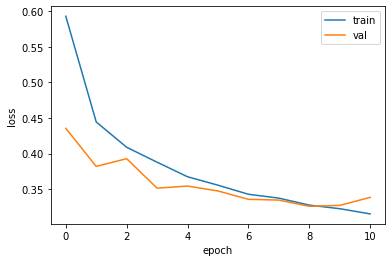

In [80]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "val"])
plt.show()

### 검증

In [81]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 1ms/step - loss: 0.3261 - accuracy: 0.8813


[0.3260958790779114, 0.8812500238418579]

# 합성곱 신경망 CNN

* 커널은 입력에 곱하는 가중치
* 필터는 뉴런 개수를 표현할 때
* 합성곱 계산을 통해 얻은 출력을 특별하게 특성 맵(feature map) 이라고한다.
* 보통 3X3 이나 5X5 가 많이 사용된다.

## 합성공 신경망의 구성요소

In [82]:
from tensorflow import keras
keras.layers.Conv2D(10, kernel_size=(3,3), activation='relu')

### 패딩

* 하지만 (3X3)의 도장으로 찍기 시작하면 특성 사이즈가 축소하게 된다
* 이를 방지하기위해 입력 배열의 주위를 가상의 원소로 채우는 것을 `패딩`이라고 한다.
>1. 여기서 0으로 패딩하는 것을 세임패딩(same padding)
>1. 그리고 패딩을 하지 않는 것을 밸리드 패딩(valid padding)

이라고한다.

In [83]:
keras.layers.Conv2D(10, kernel_size=(3,3), activation="relu", padding="same")

### 스트라이드

* 상하, 좌우를 1칸 씩 움직이는게 아니라 여러칸을 움직이는 것을 `스트라이드` stride 라고 한다.
* 스트라이드는 기본값이 1이고, 다른값은 잘 사용하지 않는다

In [84]:
keras.layers.Conv2D(10, kernel_size=(3,30), activation="relu", padding="same", strides =1)

### 풀링

* 4X4 입력값을 3가지의 3X3 필터로, 2X2 특성을 3개 만들면 (2,2,3) 의 특성맵이 생긴다
* 이 (2,2,3)의 맵을 2x2의 필터로 찍어서 계산하면 (1,1,3)의 특성맵이 된다
* 여기서 풀링에는 가중치가 없다, 가장 큰 값을 고르거나 평균값을 계산한다.
* 이를 `최대풀링`(max pooling)과 `평균풀링`(average pooling) 이라고 부른다.
* 즉 풀링은 가중치가 없고, 배열의 한 데이터에 2번씩 찍히지않는다.

In [85]:
keras.layers.MaxPooling2D(2) # 최대풀링
keras.layers.AveragePooling2D # 평균풀링

keras.layers.pooling.AveragePooling2D

## 합성곱 신경망의 전체구조

1. 데이터 준비
1. 1번 합성곱 층(same padding)
1. 1번 풀링 층(max pooling)
1. 2번 합성곱 층
1. 2번 풀링 층
1. Flatten 층
1. Dense은닉 층
1. 드롭아웃 층
1. Dense출력 층

**데이터 준비**

In [86]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

train_input, val_input, train_target, val_target = train_test_split(train_input, train_target,
                                                                     test_size=0.2, random_state=42)

# reshape를 해서 높이 차원을 1로 하면 train_test_split을 하면서 없어지게된다
# 데이터를 다 나눈뒤 reshape를 해야한다.

# reshape(-1,28,28,1)을 통해 input_shape 를 28,28,1 로 지정
train_scaled = train_input.reshape(-1,28,28,1)/255.0
test_scaled = test_input.reshape(-1,28,28,1)/255.0
val_scaled = val_input.reshape(-1,28,28,1)/255.0

In [87]:
train_input.shape, train_scaled.shape, test_input.shape, test_scaled.shape, val_scaled.shape

((48000, 28, 28),
 (48000, 28, 28, 1),
 (10000, 28, 28),
 (10000, 28, 28, 1),
 (12000, 28, 28, 1))

**첫번째 합성곱 신경망**

In [88]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=3, activation="relu",
         padding="same", input_shape=(28,28,1)))
# same padding 을 사용했으므로 28X28 은 동일하고 32개의 커널이므로 28X28X32 가 된다.

**첫번째 풀링**

In [89]:
model.add(keras.layers.MaxPooling2D(2))
# 풀링을 2로 사용했으므로 14X14X32

**두번째 합성곱 신경망**

In [90]:
model.add(keras.layers.Conv2D(64, kernel_size=3, activation="relu",
                              padding="same"))
# shape = 14X14X64

**두번째 풀링**

In [91]:
model.add(keras.layers.MaxPooling2D(2))
# shape = 7X7X64

**Flatten층**

In [92]:
model.add(keras.layers.Flatten())

**Dense은닉층**

In [93]:
model.add(keras.layers.Dense(100,activation="relu"))

**드롭아웃**

In [94]:
model.add(keras.layers.Dropout(0.4))

**Dense출력층**

In [95]:
model.add(keras.layers.Dense(10, activation="softmax"))

**정리**

In [96]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_13 (Flatten)        (None, 3136)              0         
                                                                 
 dense_31 (Dense)            (None, 100)             

### 요약

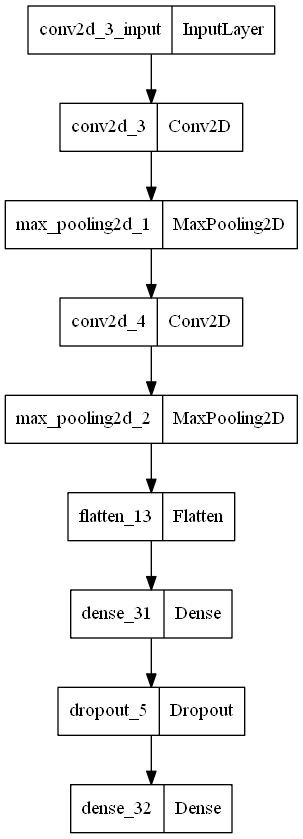

In [97]:
keras.utils.plot_model(model)

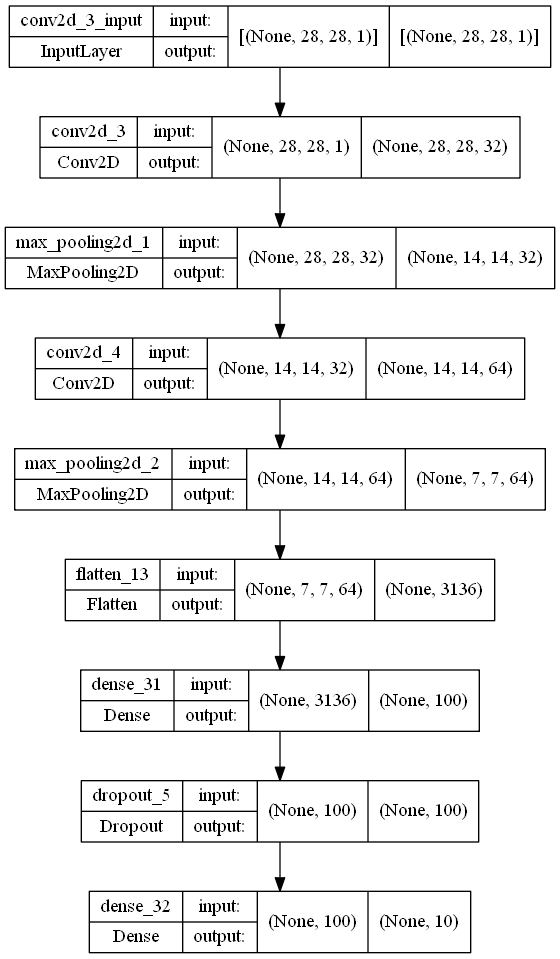

In [98]:
keras.utils.plot_model(model, show_shapes=True)

### 컴파일과 훈련

**컴파일**

In [99]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")

**콜백**

In [100]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("best-cnn-model.h5", save_best_only=True)

**조기종료**

In [101]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
# restore_best_weights = True 를 하면 훈련이 끝나고 가장 높은 점수의 epoch로 돌아가있다.

**훈련**

In [102]:
history = model.fit(train_scaled, train_target, epochs=20, validation_data=(val_scaled, val_target),
                   callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 25s 16ms/step - loss: 0.5226 - accuracy: 0.8124 - val_loss: 0.3325 - val_accuracy: 0.8798
Epoch 2/20
1500/1500 [==============================] - 24s 16ms/step - loss: 0.3416 - accuracy: 0.8771 - val_loss: 0.2731 - val_accuracy: 0.8965
Epoch 3/20
1500/1500 [==============================] - 24s 16ms/step - loss: 0.2947 - accuracy: 0.8948 - val_loss: 0.2579 - val_accuracy: 0.9035
Epoch 4/20
1500/1500 [==============================] - 24s 16ms/step - loss: 0.2636 - accuracy: 0.9055 - val_loss: 0.2332 - val_accuracy: 0.9133
Epoch 5/20
1500/1500 [==============================] - 24s 16ms/step - loss: 0.2398 - accuracy: 0.9133 - val_loss: 0.2295 - val_accuracy: 0.9150
Epoch 6/20
1500/1500 [==============================] - 24s 16ms/step - loss: 0.2196 - accuracy: 0.9191 - val_loss: 0.2269 - val_accuracy: 0.9177
Epoch 7/20
1500/1500 [==============================] - 24s 16ms/step - loss: 0.2043 - accuracy: 0.9239 - val_loss: 0.2219 -

**그래프로 확인**

C:\Users\user\AppData\Local\Temp/ipykernel_7828/3107175652.py:6: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("train", "val")
C:\Users\user\AppData\Local\Temp/ipykernel_7828/3107175652.py:6: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("train", "val")
C:\Users\user\AppData\Local\Temp/ipykernel_7828/3107175652.py:6: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("train", "val")


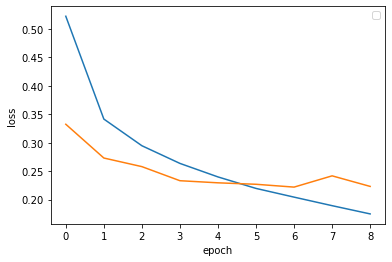

In [103]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend("train", "val")
plt.show()

In [104]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 2s 6ms/step - loss: 0.2219 - accuracy: 0.9190


[0.22191022336483002, 0.9190000295639038]

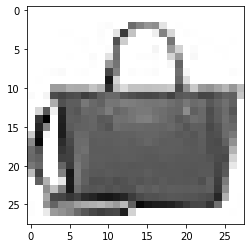

In [105]:
plt.imshow(val_scaled[0].reshape(28,28), cmap="gray_r")
# 맷플롯립의 흑백맵은 2차원이므로 reshape를 해준다.
plt.show()

[[1.0242572e-15 3.3053570e-24 2.9880644e-18 4.1950532e-16 1.2223719e-17
  1.3105835e-17 9.0791509e-18 2.3307886e-15 1.0000000e+00 1.8651465e-17]]


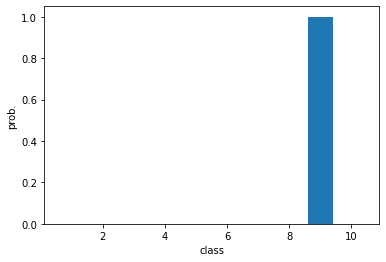

In [106]:
preds = model.predict(val_scaled[0:1])
# 인덱싱 이아니라 슬라이싱을 사용한 이유
# 인덱싱은 차원이 부서지지만 슬라이싱은 전체 차원이 유진된다.
# 인덱싱을 뽑을경우(28,28,1) 이되고
# 슬라이싱은 (1,28,28,1) 이 된다.
print(preds)
plt.bar(range(1,11), preds[0])
plt.xlabel("class")
plt.ylabel("prob.")
plt.show()
# 이를통해 완전히 9라고 예측한 것을 알 수 있다.

### 일반화 성능확인

In [107]:
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 2s 7ms/step - loss: 0.2400 - accuracy: 0.9111


[0.23996052145957947, 0.9110999703407288]

## 합성곱 신경망의 시각화

### 가중치의 시각화

In [108]:
from tensorflow import keras
model = keras.models.load_model("best-cnn-model.h5")
model.layers

In [109]:
conv = model.layers[0]
print(conv.weights[0].shape, conv.weights[1].shape)

(3, 3, 1, 32) (32,)


In [110]:
conv_weights = conv.weights[0].numpy()
print(conv_weights.mean(), conv_weights.std())

-0.029640006 0.26917472


#### 훈련모델의 가중치

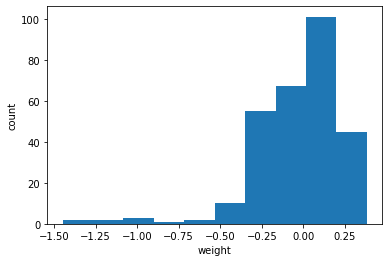

In [111]:
import matplotlib.pyplot as plt
plt.hist(conv_weights.reshape(-1, 1))
plt.xlabel("weight")
plt.ylabel("count")
plt.show()

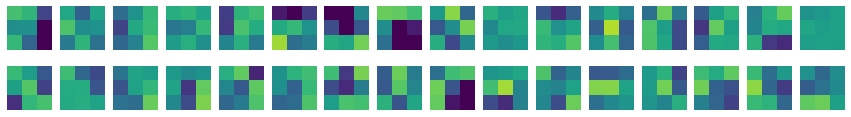

In [112]:
fig, axs = plt.subplots(2, 16, figsize=(15,2))
for i in range(2):
    for j in range(16):
        axs[i, j].imshow(conv_weights[:,:,0,i*16 +j], vmin=-0.5, vmax=0.5)
        axs[i, j].axis("off")
plt.show()

#### 훈련되지 않은 모델의 가중치

In [113]:
no_train_model = keras.Sequential()
no_train_model.add(keras.layers.Conv2D(32, kernel_size=3, activation="relu", padding="same", input_shape=(28,28,1)))

In [114]:
no_training_conv = no_train_model.layers[0]
print(no_training_conv.weights[0].shape)

(3, 3, 1, 32)


In [115]:
no_training_weights = no_training_conv.weights[0].numpy()
print(no_training_weights.mean(), no_training_weights.std())

0.0052549606 0.080510065


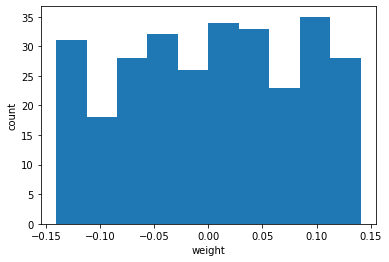

In [116]:
plt.hist(no_training_weights.reshape(-1,1))
plt.xlabel("weight")
plt.ylabel("count")
plt.show()

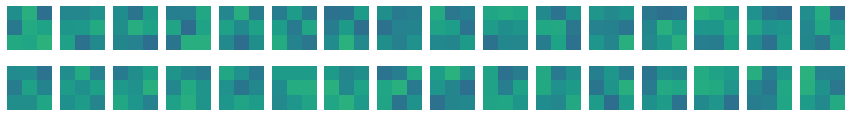

In [117]:
fig, axs = plt.subplots(2, 16, figsize=(15,2))
for i in range(2):
    for j in range(16):
        axs[i, j].imshow(no_training_weights[:,:,0,i*16+j], vmin=-0.5, vmax=0.5)
        axs[i, j].axis("off")
plt.show()

### 함수형 API

```
dense1 = keras.layers.Dense(100, activation="sigmoid")
dense2 = keras.layers.Dense(10, activation="softmax")
```
을 통해 밀집층을 만들어 둔뒤 함수형 API 를 통과시켜 다음 값을 얻을 수 있다.

```
hidden = dense1(inputs)
```

```
outputs = dense2(hidden)
```

```
model = keras.Model(inputs, outputs)
```

```
inputs = keras.Input(shape=(784,))
```

이러한 함수형 API 를 통해 합성곱층이 적용되었을때 출력과 다양한 것을 알 수 있다.

* **conv2d_input**

In [118]:
print(model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='conv2d_3_input'), name='conv2d_3_input', description="created by layer 'conv2d_3_input'")


* **합성곱 층의 출력값을 이용한 새로운 모델**

>1. model 객체의 predict() 메서드는 최종 출력층의 확률을 반환한다.
>1. conv_acti 의 predict() 메서드는 Conv2D의 출력을 반환한다.
>1. 이를 통해 합성곱 층이 반환한 이미지 세계의 시야를 볼 수 있다!

In [119]:
conv_acti = keras.Model(model.input, model.layers[0].output)

**원본 이미지**

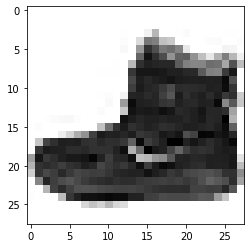

In [120]:
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
plt.imshow(train_input[0], cmap="gray_r")
plt.show()

In [121]:
inputs = train_input[0:1].reshape(-1,28,28,1)/255.0
feature_maps = conv_acti.predict(inputs)

In [122]:
print(feature_maps.shape)

(1, 28, 28, 32)


**32개의 합성곱층(1번째 합성곱층)의 활성화 영역으로 본 이미지** 

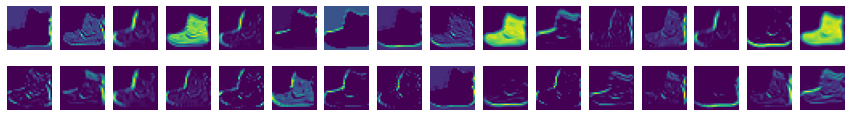

In [123]:
fig, axs = plt.subplots(2, 16, figsize=(15, 2))
for i in range(2):
    for j in range(16):
        axs[i, j].imshow(feature_maps[0,:,:,i*16 +j])
        axs[i, j].axis("off")
plt.show()

**3X3커널의 모습과 비교**

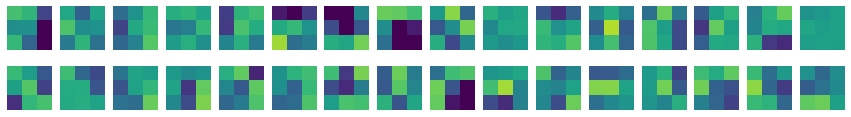

In [124]:
fig, axs = plt.subplots(2, 16, figsize=(15,2))
for i in range(2):
    for j in range(16):
        axs[i, j].imshow(conv_weights[:,:,0,i*16 +j], vmin=-0.5, vmax=0.5)
        axs[i, j].axis("off")
plt.show()

**64개의 합성곱층(두번째 합성곱층)의 활성화영역으로 본 이미지**

In [125]:
conv2 = model.layers[2]
print(conv2.weights[0].shape, conv2.weights[1].shape)
conv2_weights = conv2.weights[0].numpy()
conv2_weights.shape

(3, 3, 32, 64) (64,)


(3, 3, 32, 64)

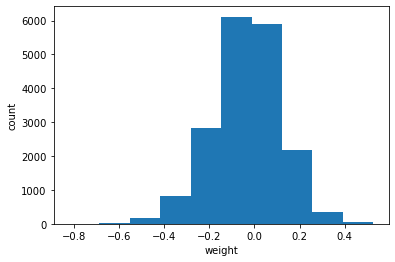

In [126]:
plt.hist(conv2_weights.reshape(-1, 1))
plt.xlabel("weight")
plt.ylabel("count")
plt.show()

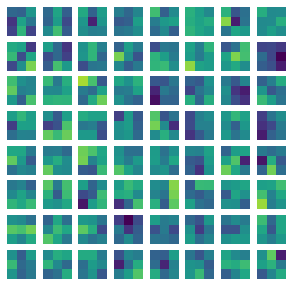

In [127]:
fig, axs = plt.subplots(8, 8, figsize=(5,5))
for i in range(8):
    for j in range(8):
        axs[i, j].imshow(conv2_weights[:,:,0,i*8 +j], vmin=-0.5, vmax=0.5)
        axs[i, j].axis("off")
plt.show()

In [128]:
conv2_acti = keras.Model(model.input, model.layers[2].output)
inputs = train_input[0:1].reshape(-1, 28, 28, 1) /255.0
feature_maps = conv2_acti.predict(inputs)
print(feature_maps.shape)

(1, 14, 14, 64)


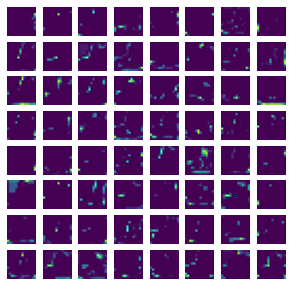

In [129]:
fig, axs = plt.subplots(8, 8, figsize=(5,5))
for i in range(8):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0,:,:,i*8+j])
        axs[i, j].axis("off")
plt.show()

# 순환신경망 RNN

* 순차 데이터(Sequential data)는 **텍스트**나 **시계열 데이터**와 같이 순서에 의미가 있는 데이터를 말한다.
* 입력 데이터의 흐름이 앞으로만 전달되어 계산된 샘플은 버려지는 신경망을 **피드포워드 신경망(FFNN)** 이라고한다.
* 합성곱 신경망(CNN)과 완전 연결 신경망(DNN)은 피드포워드 신경망에 속한다고 볼 수 있다.



* 신경망이 이전에 처리했던 샘플을 다음 샘플을 위해 순환되어 재사용 할 수 있는 신경망이 **`순환신경망`**이다
* 이렇게 샘플을 처리하는 한 단계를 **타임스텝(timestep)**이라고 한다.
* 순환 신경망은 층을 **셀(cell)** 이라고 부른다.
* 셀의 출력을 **은닉 상태**라고 부른다.
* 순환층의 활성화 함수로는 **하이퍼볼릭 탄젠트(tanh)**가 많이 사용된다.
* 순환층은 타임스텝에서 오는 가중치가 더해져 가중치가 2개이다.
* 타임스텝1은 가중치가 없고 0이다.
* 입력층 뉴런 a개, 순환층 뉴런 b개의 가중치 개수는 $a \times b + b^2 + b$가 된다.
* 또한 마지막 타임스텝은 은닉상태로 $h_f$로 받게된다.
* 순환층은 마지막 출력이 1차원으로 Flatten 층이 필요없다.

## 자연어 처리, 리뷰데이터분석

* 자연어 처리(natural language processing, NLP)에서는 훈련데이터를 말뭉치(corpus)라고 부른다.
* 1은 문장의 시작
* 2는 어휘사전에 없는 토큰
* 0은 패딩을 뜻한다.

### 데이터 준비

In [130]:
from tensorflow.keras.datasets import imdb
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words = 500)
# 어휘사전에는 500개의 단어를 넣어뒀다

In [131]:
# 샘플의 크기가 훈련과 테스트 각각 25000개
print(train_input.shape, test_input.shape)

(25000,) (25000,)


In [132]:
# 훈련데이터의 각 데이터는 리스트로 이루어져있으며 그 길이는 다 다르다
print(len(train_input[0]), len(train_input[1]))

218 189


In [133]:
# 첫번째 데이터를 살펴보면 정수가 들어있다.
# 여기서 2는 500개 단어의 어휘사전에 들어있지 않다는 뜻이다.
print(train_input[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [134]:
# 타깃 데이터 출력
# 즉 리뷰가 긍정인지 부정인지를 판단하는 것이다.
print(train_target[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


훈련세트에서 검증세트를 떼어 두자.

In [135]:
from sklearn.model_selection import train_test_split
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2,
                                                                    random_state=42 )

각 리뷰의 길이를 계산하여 넘파이 배열에 저장
> 평균적인 리뷰의 길이와, 가장 짧은 리뷰의 길이, 가장 긴 리뷰의 길이를 확인하기 위해

In [136]:
import numpy as np
lengths = np.array([len(x) for x in train_input])

In [137]:
print(np.mean(lengths), np.median(lengths))

239.00925 178.0


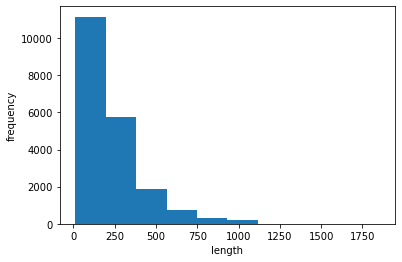

In [138]:
import matplotlib.pyplot as plt
plt.hist(lengths)
plt.xlabel("length")
plt.ylabel("frequency")
plt.show()
# 데이터가 한쪽으로 치우친것을 확인할 수 잇다.

### 시퀸스데이터 길이조절

`pad_sequences()`
* maxlen를 지정하고 그 보다 긴경우는 잘라내고, 짧은경우는 0으로 패딩한다.
* 패딩을 할때는 기본으로 앞부분을 0으로 채우게 된다.
* 뒷부분에 패딩을 하려면 매개변수`padding="post"`를 통해 바꿀 수 있다.


* 길이가 긴 경우 기본으로 앞부분을 잘라낸다. 뒷부분의 정보가 유용할것으로 예상하고 설정되었다.
* 뒷부분을 잘라내고 싶다면 매개변수`truncating="post"`를 통해 바꿀 수 있다.

In [139]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [140]:
print(train_input.shape, train_seq.shape)
# train_input은 리스트로 이루어진 배열이였지만
# train_seq에서 리스트를 길이 100으로 제한하며 풀어내고 20000,100 의 2차원 배열로 만듬

(20000,) (20000, 100)


In [141]:
print(train_seq[0])
# 샘플의 앞뒤에 패딩값 0 이 없는 것을 보면 100보다 길었을 것으로 볼 수 있다.

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


In [142]:
print(train_input[0][-10:]) # 훈련데이터의 뒷부분 10개
print(train_input[0][:10]) # 훈련데이터의 앞부분 10개
# 앞뒤를 확인해본결과 훈련데이터의 앞부분이 잘린것을 확인할 수 있다.

[6, 2, 46, 7, 14, 20, 10, 10, 470, 158]
[1, 73, 89, 81, 25, 60, 2, 6, 20, 141]


In [143]:
print(train_seq[5])
# 앞부분에 0이 있는 것으로 원래 길이가 100이 되지 않았다는 것을 확인할 수 있다.

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


### 순환신경망 만들기

`SimpleRNN`클래스를 이용하기

In [144]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(8, input_shape = (100,500)))
# input_shape 를 100,500 으로 한 이유
# 100 -> 샘플의 길이를 100으로 했기때문
# 500 -> 어휘사전의 길이가 500이기 때문
model.add(keras.layers.Dense(1, activation="sigmoid"))

#### 원-핫 인코딩

* 출력층에서 만든 확률과 크로스 엔트로피 손실을 계산하기 위해
* `to_categorical()`함수를 통해 자동으로 배열을 반환

In [145]:
train_oh = keras.utils.to_categorical(train_seq)
val_oh = keras.utils.to_categorical(val_seq)
train_oh.shape

(20000, 100, 500)

In [146]:
print(train_oh[0][0][:12])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [147]:
print(np.sum(train_oh[0][0]))

1.0


In [148]:
model.summary()
# 전달된 샘플의 크기는 (100,500)이지만
# output은 뉴런의 개수인 8 인것을 볼 수 있다.
# 파라미터수 계산해보기
# 500*8 = 4000
# 8*8 = 64
# 8
# 파라미터수 => 4072개 

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 4072      
                                                                 
 dense_33 (Dense)            (None, 1)                 9         
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


### 순환신경망 훈련하기

In [149]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss="binary_crossentropy", metrics=["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("best-simplernn-model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(train_oh, train_target, epochs=100, batch_size=64,
                    validation_data=(val_oh, val_target),
                   callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 8s 22ms/step - loss: 0.6957 - accuracy: 0.5268 - val_loss: 0.6790 - val_accuracy: 0.5706
Epoch 2/100
313/313 [==============================] - 7s 21ms/step - loss: 0.6683 - accuracy: 0.5979 - val_loss: 0.6532 - val_accuracy: 0.6230
Epoch 3/100
313/313 [==============================] - 7s 21ms/step - loss: 0.6426 - accuracy: 0.6388 - val_loss: 0.6312 - val_accuracy: 0.6518
Epoch 4/100
313/313 [==============================] - 6s 21ms/step - loss: 0.6168 - accuracy: 0.6780 - val_loss: 0.6067 - val_accuracy: 0.6894
Epoch 5/100
313/313 [==============================] - 6s 21ms/step - loss: 0.5924 - accuracy: 0.7060 - val_loss: 0.5854 - val_accuracy: 0.7110
Epoch 6/100
313/313 [==============================] - 6s 21ms/step - loss: 0.5718 - accuracy: 0.7272 - val_loss: 0.5682 - val_accuracy: 0.7286
Epoch 7/100
313/313 [==============================] - 7s 21ms/step - loss: 0.5544 - accuracy: 0.7417 - val_loss: 0.5517 - val_accuracy:

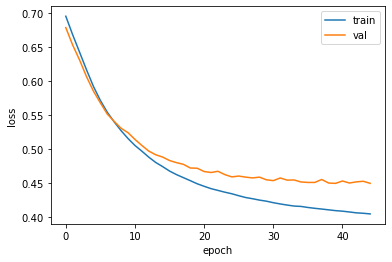

In [151]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "val"])
plt.show()

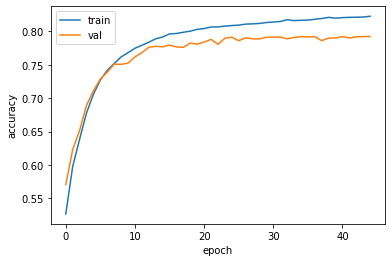

In [152]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train", "val"])
plt.show()

* 대략 20번째 epoch 부터 val_loss의 감소가 둔해지는 것을 볼 수 있다.
* 원-핫 인코딩의 단점은 입력데이터가 엄청나게 커진다는 것이다.

In [153]:
print(train_seq.nbytes, train_oh.nbytes)

8000000 4000000000


## 단어 임베딩 사용하기

`word embedding`

* 각 단어를 고정된 크기의 실수 벡터로 바꿔준다
* 이런 벡터는 원-핫 인코딩된 벡터보다 훨씬 의미 있는 값으로 채워져 있어서 자연어 처리에서 더 좋은 성능을 내는 경우가 많다
* 이 클래스를 다른 층처럼 모델에 추가하면 처음에는 모든 벡터가 랜덤하게 초기화되지만 훈련을 통해 데이터에서 좋은 단어 임베딩을 학습한다.
* 단어 임베딩의 장점은 정수 데이터를 받는다는 것이다.
* 즉 train_oh 배열이 아니라, train_seq를 사용할 수 있어서 메모리를 훨씬 효율적으로 사용할 수 있다.
* 원-핫 인코딩은 샘플1개를 500차원으로 늘렸기 때문에 (100, ) -> (100, 500)으로 커졌다.
* 임베딩은 (100, ) -> (100, 20) 으로 훨씬 작은 크기로도 단어를 잘 표현할 수 있다.

In [154]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length=100))
# 임베딩의 매개변수
# 첫번째 : 어휘사전 크기
# 두번째 : 임베딩 벡터의 크기
# 세번째 : 입력 시퀸스의 길이 -> 샘플의 길이를 100으로 만들었기 때문에 100으로 설정
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation="sigmoid"))

In [155]:
model2.summary()
# 파라미터 개수
# 임베딩 : 500개의 각 토큰을 16 벡터로 변경하기 때문에 500X16 = 8000
# simpleRNN : 16 X 8 = 128, 8 X 8 =64,  8 => 128+64+8 = 200

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 8)                 200       
                                                                 
 dense_34 (Dense)            (None, 1)                 9         
                                                                 
Total params: 8,209
Trainable params: 8,209
Non-trainable params: 0
_________________________________________________________________


In [156]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss="binary_crossentropy", metrics=["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("best-embedding-model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)
history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 8s 21ms/step - loss: 0.6695 - accuracy: 0.5910 - val_loss: 0.6369 - val_accuracy: 0.6608
Epoch 2/100
313/313 [==============================] - 6s 20ms/step - loss: 0.6088 - accuracy: 0.6993 - val_loss: 0.5915 - val_accuracy: 0.7156
Epoch 3/100
313/313 [==============================] - 6s 20ms/step - loss: 0.5703 - accuracy: 0.7398 - val_loss: 0.5612 - val_accuracy: 0.7402
Epoch 4/100
313/313 [==============================] - 6s 20ms/step - loss: 0.5405 - accuracy: 0.7618 - val_loss: 0.5364 - val_accuracy: 0.7540
Epoch 5/100
313/313 [==============================] - 6s 20ms/step - loss: 0.5131 - accuracy: 0.7725 - val_loss: 0.5124 - val_accuracy: 0.7658
Epoch 6/100
313/313 [==============================] - 6s 19ms/step - loss: 0.4907 - accuracy: 0.7819 - val_loss: 0.4970 - val_accuracy: 0.7732
Epoch 7/100
313/313 [==============================] - 6s 20ms/step - loss: 0.4756 - accuracy: 0.7875 - val_loss: 0.4823 - val_accuracy:

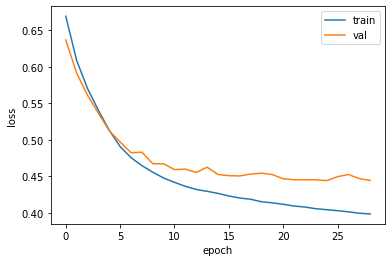

In [157]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train","val"])
plt.show()

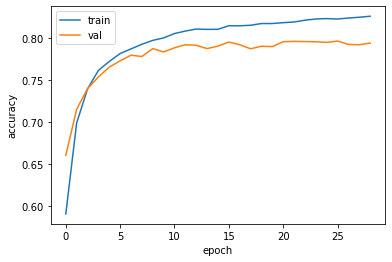

In [158]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train","val"])
plt.show()

## LSTM 과 GRU

### LSTM

* Long Short-Term Memory의 약자이다. 말 그대로 단기 기억을 오래 기억하기 위해 고안되었다.
* 입력과 가중치를 곱하고 절편을 더해 활성화 함수를 통과시키는 구조를 여러개 가진다.
* 이렇게 계산된 결과는 다음 타임스텝에 재사용된다.
* LSTM 에는 순환되는 상태가 은닉 상태(h)와 셀 상태(c) 두가지가 있다.


* 은닉 상태(h)를 만드는 방법
> 1. 입력과 이전 타임스텝의 은닉 상태를 가중치에 곱한 후 활성화 함수를 통과시켜 다음 은닉상태를 만든다. (이때 시그모이드 활성화 함수를 사용한다.)
> 1. 시그모이드 활성화 함수($w_x$와 함께 tanh 활성화 함수($w_h$를 통과한 어떤 값과 곱해져서 은닉상태를 만든다. 여기서 가중치를 합쳐서 $w_o$ 라고 한다.


* 셀 상태(c)를 만드는 방법
> 1. 이때 셀 상태(c)는 다음 층으로 전달되지 않고 LSTM 셀 에서 순환만 되는 값이다.
> 1. 입력과 은닉 생트를 또 다른 가중치$w_f$에 곱한 다음 시그모이드 함수($w_x$)를 통과시킨다.
> 1. 이전 타임스텝의 셀 상태와 곱하여 새로운 셀 상태를 만든다.
> 1. 이 새로운 셀 상태가 $w_h$를 통과하여 새로운 은닉 상태를 만드는 데 기여한다.
> 1. 새로운 가중치 $w_i$, $w_j$ 를 만들고 각각 $w_x$, $w_h$를 통과한후 두 결과를 곱한 후 이전 셀 상태와 더한다.
> 1. 이 결과가 새로운 셀 상태가 된다.

#### LSTM 훈련하기

In [159]:
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target,
                                                                   test_size=0.2, random_state=42)

In [160]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [161]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.Embedding(500, 16, input_length=100))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation="sigmoid"))

In [162]:
model.summary()
# simpleRNN 은 파라미터가 200이었다.
# LSTM은 셀이 4개 있으므로 200X4 = 800 이 된다.

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense_35 (Dense)            (None, 1)                 9         
                                                                 
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


In [163]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss="binary_crossentropy", metrics=["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("best-lstm-model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)
history = model.fit(train_seq, train_target, epochs=100, batch_size=64,
                   validation_data=(val_seq, val_target),
                   callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 13s 34ms/step - loss: 0.6923 - accuracy: 0.5487 - val_loss: 0.6913 - val_accuracy: 0.5914
Epoch 2/100
313/313 [==============================] - 10s 32ms/step - loss: 0.6892 - accuracy: 0.6265 - val_loss: 0.6866 - val_accuracy: 0.6522
Epoch 3/100
313/313 [==============================] - 10s 32ms/step - loss: 0.6784 - accuracy: 0.6733 - val_loss: 0.6621 - val_accuracy: 0.6854
Epoch 4/100
313/313 [==============================] - 10s 33ms/step - loss: 0.6134 - accuracy: 0.7103 - val_loss: 0.5824 - val_accuracy: 0.7258
Epoch 5/100
313/313 [==============================] - 11s 34ms/step - loss: 0.5677 - accuracy: 0.7326 - val_loss: 0.5539 - val_accuracy: 0.7464
Epoch 6/100
313/313 [==============================] - 11s 34ms/step - loss: 0.5436 - accuracy: 0.7469 - val_loss: 0.5362 - val_accuracy: 0.7580
Epoch 7/100
313/313 [==============================] - 11s 34ms/step - loss: 0.5235 - accuracy: 0.7602 - val_loss: 0.5183 - val_ac

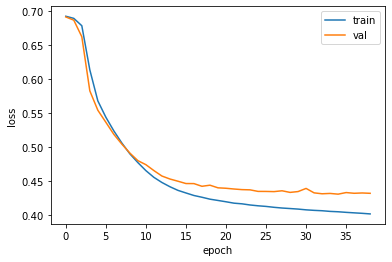

In [164]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train","val"])
plt.show()

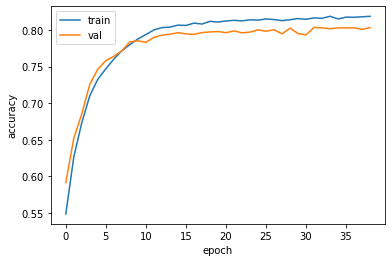

In [165]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train","val"])
plt.show()

#### 순환층에 드롭아웃 적용하기

In [166]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation="sigmoid"))

In [167]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss="binary_crossentropy", metrics=["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("best-dropout-model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)
history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 14s 36ms/step - loss: 0.6923 - accuracy: 0.5387 - val_loss: 0.6913 - val_accuracy: 0.5882
Epoch 2/100
313/313 [==============================] - 11s 35ms/step - loss: 0.6894 - accuracy: 0.6084 - val_loss: 0.6864 - val_accuracy: 0.6614
Epoch 3/100
313/313 [==============================] - 11s 34ms/step - loss: 0.6747 - accuracy: 0.6658 - val_loss: 0.6489 - val_accuracy: 0.6948
Epoch 4/100
313/313 [==============================] - 11s 34ms/step - loss: 0.6258 - accuracy: 0.6888 - val_loss: 0.6036 - val_accuracy: 0.7064
Epoch 5/100
313/313 [==============================] - 11s 35ms/step - loss: 0.5937 - accuracy: 0.7110 - val_loss: 0.5793 - val_accuracy: 0.7294
Epoch 6/100
313/313 [==============================] - 11s 35ms/step - loss: 0.5704 - accuracy: 0.7307 - val_loss: 0.5559 - val_accuracy: 0.7434
Epoch 7/100
313/313 [==============================] - 11s 34ms/step - loss: 0.5485 - accuracy: 0.7447 - val_loss: 0.5362 - val_ac

313/313 [==============================] - 11s 34ms/step - loss: 0.4061 - accuracy: 0.8140 - val_loss: 0.4274 - val_accuracy: 0.8030
Epoch 58/100
313/313 [==============================] - 6s 20ms/step - loss: 0.4056 - accuracy: 0.8142 - val_loss: 0.4271 - val_accuracy: 0.8050
Epoch 59/100
313/313 [==============================] - 5s 15ms/step - loss: 0.4065 - accuracy: 0.8112 - val_loss: 0.4275 - val_accuracy: 0.8054
Epoch 60/100
313/313 [==============================] - 5s 15ms/step - loss: 0.4051 - accuracy: 0.8127 - val_loss: 0.4273 - val_accuracy: 0.8066
Epoch 61/100
313/313 [==============================] - 5s 16ms/step - loss: 0.4049 - accuracy: 0.8145 - val_loss: 0.4269 - val_accuracy: 0.8022
Epoch 62/100
313/313 [==============================] - 5s 15ms/step - loss: 0.4049 - accuracy: 0.8134 - val_loss: 0.4278 - val_accuracy: 0.8058
Epoch 63/100
313/313 [==============================] - 5s 15ms/step - loss: 0.4043 - accuracy: 0.8157 - val_loss: 0.4260 - val_accuracy: 0.80

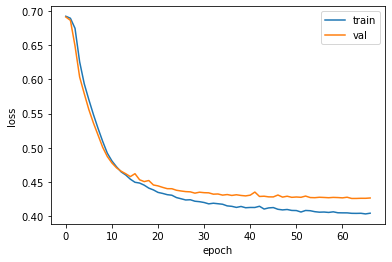

In [168]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train","val"])
plt.show()

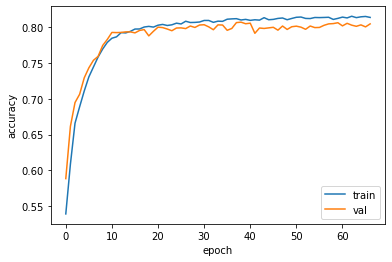

In [169]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train","val"])
plt.show()

#### 층 2개 연결하기

* 순환층의 은닉상태는 샘플의 마지막 타임스텝에 대한 은닉상태만 다음 층으로 전달한다.
* 하지만 순환층이 여러겹이 되면 모든 순환층에 순차 데이터가 필요하다.
* 따라서 앞쪽의 순환층이 모든 타임스텝에 대한 은닉 상태를 출력해야한다.
* 오직 마지막 순환층만 마지막 타임스텝의 은닉 상태를 출력해야한다.

In [170]:
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(500, 16, input_length=100))
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
model3.add(keras.layers.LSTM(8, dropout=0.3))
model3.add(keras.layers.Dense(1, activation="sigmoid"))

In [171]:
model3.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm_2 (LSTM)               (None, 100, 8)            800       
                                                                 
 lstm_3 (LSTM)               (None, 8)                 544       
                                                                 
 dense_37 (Dense)            (None, 1)                 9         
                                                                 
Total params: 9,353
Trainable params: 9,353
Non-trainable params: 0
_________________________________________________________________


In [172]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop, loss="binary_crossentropy", metrics=["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("best-2rnn-model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model3.fit(train_seq, train_target, epochs=100, batch_size = 64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 11s 29ms/step - loss: 0.6922 - accuracy: 0.5415 - val_loss: 0.6914 - val_accuracy: 0.5294
Epoch 2/100
313/313 [==============================] - 9s 27ms/step - loss: 0.6875 - accuracy: 0.5937 - val_loss: 0.6821 - val_accuracy: 0.6548
Epoch 3/100
313/313 [==============================] - 9s 27ms/step - loss: 0.6541 - accuracy: 0.6578 - val_loss: 0.6106 - val_accuracy: 0.7078
Epoch 4/100
313/313 [==============================] - 9s 27ms/step - loss: 0.5806 - accuracy: 0.7179 - val_loss: 0.5546 - val_accuracy: 0.7390
Epoch 5/100
313/313 [==============================] - 9s 28ms/step - loss: 0.5453 - accuracy: 0.7365 - val_loss: 0.5237 - val_accuracy: 0.7580
Epoch 6/100
313/313 [==============================] - 9s 29ms/step - loss: 0.5213 - accuracy: 0.7525 - val_loss: 0.5075 - val_accuracy: 0.7616
Epoch 7/100
313/313 [==============================] - 9s 29ms/step - loss: 0.5034 - accuracy: 0.7635 - val_loss: 0.4897 - val_accuracy

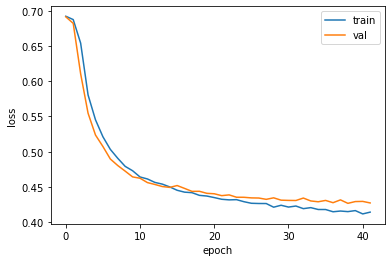

In [173]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train","val"])
plt.show()

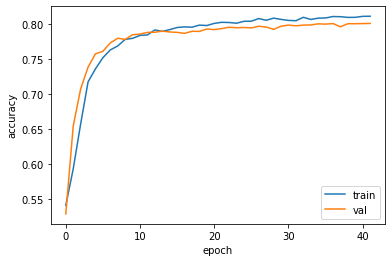

In [174]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train","val"])
plt.show()

### GRU

* Gated Recurrent Unit, LSTM을 간소화한 버전
* LSTM과 달리 셀 상태를 계산하지 않고 은닉 상태 하나만을 포함하고 있다.
* GRU 셀에는 은닉상태와 입력에 가중치를 곱하고 절편을 더하는 작은 셀이 3개 있다.
* 2개는 시그모이드 활성화 함수($w_s$)를 사용하고 하나는 tanh 활성화 함수($w_h$)를 사용한다.
* GRU 셀은 LSTM보다 가중치가 적기 때문에 계산량이 적지만 LSTM 못지않은 좋은 성능을 낸다.

#### GRU 훈련하기

In [175]:
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(500, 16, input_length=100))
model4.add(keras.layers.GRU(8))
model4`.add(keras.layers.Dense(1, activation="sigmoid"))

In [176]:
model4.summary()
# GRU 파라미터 개수
# GRU는 3개의 작은 셀, 입력과 은닉상태에 곱하는 가중치, 절편
# 입력에 곱하는 가중치 16X8(뉴런) =128
# 은닉상태에 곱하는 가중치 8(뉴런)X8(뉴런) = 64
# 절편은 뉴런마다 1개씩, 8(뉴런)
# 모두 더하면 200개
# 이런 작은 셀이 3개 => 600개
# 작은 셀 1개당 뉴런의 절편 => 3X8(뉴런) = 24
# 총 합 624

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 16)           8000      
                                                                 
 gru (GRU)                   (None, 8)                 624       
                                                                 
 dense_38 (Dense)            (None, 1)                 9         
                                                                 
Total params: 8,633
Trainable params: 8,633
Non-trainable params: 0
_________________________________________________________________


In [177]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model4.compile(optimizer=rmsprop, loss="binary_crossentropy",
              metrics=["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("best-gru-model.h5",
                                               save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                 restore_best_weights=True)
history = model4.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 7s 16ms/step - loss: 0.6927 - accuracy: 0.5224 - val_loss: 0.6920 - val_accuracy: 0.5476
Epoch 2/100
313/313 [==============================] - 5s 16ms/step - loss: 0.6907 - accuracy: 0.5590 - val_loss: 0.6897 - val_accuracy: 0.5710
Epoch 3/100
313/313 [==============================] - 5s 16ms/step - loss: 0.6875 - accuracy: 0.5850 - val_loss: 0.6858 - val_accuracy: 0.5886
Epoch 4/100
313/313 [==============================] - 5s 16ms/step - loss: 0.6821 - accuracy: 0.6141 - val_loss: 0.6793 - val_accuracy: 0.6128
Epoch 5/100
313/313 [==============================] - 5s 16ms/step - loss: 0.6729 - accuracy: 0.6373 - val_loss: 0.6680 - val_accuracy: 0.6334
Epoch 6/100
313/313 [==============================] - 5s 16ms/step - loss: 0.6570 - accuracy: 0.6521 - val_loss: 0.6485 - val_accuracy: 0.6532
Epoch 7/100
313/313 [==============================] - 5s 16ms/step - loss: 0.6277 - accuracy: 0.6774 - val_loss: 0.6084 - val_accuracy:

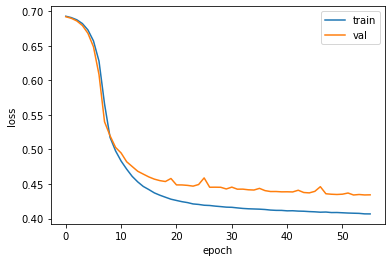

In [178]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train","val"])
plt.show()

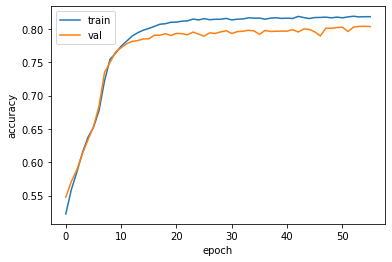

In [179]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train","val"])
plt.show()